In [1]:
# add basic large number array and graphs support

import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
# bring in the keras suport for custoom layers

#from keras import backend as K
#from keras.engine.topology import Layer

In [4]:
# bring in keras support for basic machine learning model pieces
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, Activation
from keras.optimizers import Adam
from keras import objectives

In [6]:
# create a python generator that will output fictional stock trading 

class TradeGenerator:
    def __init__(self, count=10000):
        # limit for each "for" usage
        self.count = count

        # config on how the behavours the "stock" might product
        self.spike_rate = 0.80 + 0.2*np.random.uniform()
        self.cycle_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_rate = 0.80 + 0.2*np.random.uniform()
        self.trend_scale = 4.0
        
        # inital price and average and trending direction
        self.value = 100
        self.ema = self.value
        self.trend = self.trend_scale * np.random.uniform()
        
    def __iter__(self):
        # produce a new sample point for the stock
        while self.count > 0:
            self.count -= 1
        
            self.value += np.random.normal() + self.trend

            # perform a "spike" action in the stock
            #  ie this where where some news is released that move the market
            if np.random.uniform() > self.spike_rate:
                self.value += (np.random.uniform() - 0.5)*0.3 * self.value

            # perfom a "cycling" action in the stock
            #  ie this is where some new value of the stock has seasonal effects
            ratio = 0.95
            self.ema = ratio * self.ema + (1.0 - ratio) * self.value            
            if np.random.uniform() > self.cycle_rate:
                self.trend = (self.ema - self.value) / (np.random.uniform() * 20 + 10)
            
            # re-trending
            #  ie this where where the seasonal effect is fundementally changed (ie a typhoon damages crops)
            if np.random.uniform() > self.trend_rate:
                # trend change
                self.trend = self.trend_scale * np.random.normal() 
                
            # ground point.. stop the stock from actually failing.. 
            if self.value <= 0.0:
                self.value = 1.0

            yield(self.value)        

In [7]:
# Using the TradeGenerator above run it a few times to build
# a resonable pool of trading sessions we can learn on
# we are producing the "past" data and a few more "future" data points
def generate(sampleSize   =600,
             samplePast   =20,
             samplesFuture=5):

    sampleLength = samplePast + samplesFuture
    
    trades_past  = []
    x            = []
    y            = []
    trades_future= []
    
    for i in range(sampleSize):
        seq = np.array([i for i in TradeGenerator(count=sampleLength)])

        # normalize data to "now" point
        seq = seq / seq[samplePast]

        trades_past.append(seq[:samplePast])
        trades_future.append(seq[samplePast:])


            
    return np.array(trades_past), np.array(trades_future)

In [8]:
# now actually get the training data
trades_past,trades_future = generate()

In [9]:
# and check what shapes it has
trades_past.shape,trades_future.shape

((600, 20), (600, 5))

In [10]:
# now we are going to define a Machine learning model

# first find out the number of input and output samples we need to handle
inputDim  = trades_past.shape[1]
outputDim = trades_future.shape[1]

# create a simple 3 layer network each layer is 128 neurons wide.  
i = Input(shape=(inputDim,))
x = Dense(128)(i)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(128)(x)
x = Activation('relu')(x)
x = Dense(outputDim)(x)

model_train = Model(inputs=i, outputs=x)
model_train.summary()

# Now setup the trainer for the network in our case we use the "adam" optimizer 
# and a "mean square error" (mse) loss function
opt = Adam(lr=0.001)
model_train.compile(loss='mse',optimizer=opt)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2688      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_2 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
__________

In [12]:
# run the training using the generated data
hist = model_train.fit(trades_past, trades_future, batch_size=trades_past.size, epochs=10000, verbose=1)

Epoch 1/10000
600/600 [==============================] - 0s 474us/step - loss: 1.2159
Epoch 2/10000
600/600 [==============================] - 0s 7us/step - loss: 0.8711
Epoch 3/10000
600/600 [==============================] - 0s 6us/step - loss: 0.6503
Epoch 4/10000
600/600 [==============================] - 0s 7us/step - loss: 0.4820
Epoch 5/10000
600/600 [==============================] - 0s 7us/step - loss: 0.3592
Epoch 6/10000
600/600 [==============================] - 0s 7us/step - loss: 0.2832
Epoch 7/10000
600/600 [==============================] - 0s 8us/step - loss: 0.2399
Epoch 8/10000
600/600 [==============================] - 0s 8us/step - loss: 0.2200
Epoch 9/10000
600/600 [==============================] - 0s 7us/step - loss: 0.2157
Epoch 10/10000
600/600 [==============================] - 0s 7us/step - loss: 0.2146
Epoch 11/10000
600/600 [==============================] - 0s 7us/step - loss: 0.2060
Epoch 12/10000
600/600 [==============================] - 0s 7us/step - 

Epoch 98/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0114
Epoch 99/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0113
Epoch 100/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0113
Epoch 101/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0112
Epoch 102/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0112
Epoch 103/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0111
Epoch 104/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0111
Epoch 105/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0110
Epoch 106/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0109
Epoch 107/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0109
Epoch 108/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0108
Epoch 109/10000
600/600 [==============================]

Epoch 194/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0078
Epoch 195/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0078
Epoch 196/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0077
Epoch 197/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0077
Epoch 198/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0077
Epoch 199/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0077
Epoch 200/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0077
Epoch 201/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0077
Epoch 202/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0076
Epoch 203/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0076
Epoch 204/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0076
Epoch 205/10000
600/600 [=============================

Epoch 290/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0065
Epoch 291/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0064
Epoch 292/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 293/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 294/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0065
Epoch 295/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0065
Epoch 296/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 297/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 298/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0064
Epoch 299/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0063
Epoch 300/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0063
Epoch 301/10000
600/600 [=============================

Epoch 386/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 387/10000
600/600 [==============================] - 0s 5us/step - loss: 0.0059
Epoch 388/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 389/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 390/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 391/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 392/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 393/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 394/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0059
Epoch 395/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0059
Epoch 396/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 397/10000
600/600 [=============================

600/600 [==============================] - 0s 7us/step - loss: 0.0056
Epoch 482/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0056
Epoch 483/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0056
Epoch 484/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0056
Epoch 485/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0056
Epoch 486/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0057
Epoch 487/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0057
Epoch 488/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0058
Epoch 489/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0059
Epoch 490/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0060
Epoch 491/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0060
Epoch 492/10000
600/600 [==============================] - 0s 8us/step

Epoch 577/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 578/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0055
Epoch 579/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 580/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0056
Epoch 581/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0056
Epoch 582/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0056
Epoch 583/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0056
Epoch 584/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0056
Epoch 585/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0055
Epoch 586/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 587/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0054
Epoch 588/10000
600/600 [=============================

Epoch 673/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 674/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 675/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 676/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 677/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 678/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 679/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 680/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0052
Epoch 681/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0052
Epoch 682/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 683/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0052
Epoch 684/10000
600/600 [=============================

Epoch 769/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0052
Epoch 770/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 771/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0053
Epoch 772/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 773/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0052
Epoch 774/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0052
Epoch 775/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 776/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0051
Epoch 777/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0051
Epoch 778/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 779/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0050
Epoch 780/10000
600/600 [=============================

Epoch 865/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 866/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 867/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 868/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0051
Epoch 869/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 870/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0052
Epoch 871/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0053
Epoch 872/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0055
Epoch 873/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0056
Epoch 874/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0058
Epoch 875/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0059
Epoch 876/10000
600/600 [=============================

600/600 [==============================] - 0s 8us/step - loss: 0.0049
Epoch 961/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0050
Epoch 962/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 963/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0050
Epoch 964/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0049
Epoch 965/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 966/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 967/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 968/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0049
Epoch 969/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0049
Epoch 970/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0049
Epoch 971/10000
600/600 [==============================] - 0s 6us/step

Epoch 1055/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0047
Epoch 1056/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1057/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1058/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0048
Epoch 1059/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1060/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 1061/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1062/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 1063/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1064/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 1065/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1066/10000
600/600 [=================

600/600 [==============================] - 0s 5us/step - loss: 0.0047
Epoch 1150/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 1151/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0047
Epoch 1152/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0048
Epoch 1153/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0048
Epoch 1154/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1155/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0049
Epoch 1156/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0050
Epoch 1157/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 1158/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0051
Epoch 1159/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0051
Epoch 1160/10000
600/600 [==============================] - 

Epoch 1244/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1245/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 1246/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0051
Epoch 1247/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0052
Epoch 1248/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0054
Epoch 1249/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 1250/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0055
Epoch 1251/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 1252/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0051
Epoch 1253/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0048
Epoch 1254/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0047
Epoch 1255/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0046
Epoch 1339/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 1340/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 1341/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 1342/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1343/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1344/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1345/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1346/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1347/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1348/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0046
Epoch 1349/10000
600/600 [==============================] -

Epoch 1433/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 1434/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 1435/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0046
Epoch 1436/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0046
Epoch 1437/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 1438/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 1439/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1440/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 1441/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 1442/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1443/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1444/10000
600/600 [==============

600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1528/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 1529/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 1530/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 1531/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 1532/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0047
Epoch 1533/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 1534/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0049
Epoch 1535/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0050
Epoch 1536/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 1537/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0052
Epoch 1538/10000
600/600 [==============================] -

Epoch 1622/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0049
Epoch 1623/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0048
Epoch 1624/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0046
Epoch 1625/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 1626/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1627/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1628/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0044
Epoch 1629/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1630/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 1631/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 1632/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 1633/10000
600/600 [==============

600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1717/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1718/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1719/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1720/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1721/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1722/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0043
Epoch 1723/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1724/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1725/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0043
Epoch 1726/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1727/10000
600/600 [==============================] -

Epoch 1811/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1812/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1813/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1814/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 1815/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1816/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 1817/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 1818/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1819/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 1820/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1821/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 1822/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 1906/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 1907/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 1908/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 1909/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 1910/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1911/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0043
Epoch 1912/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 1913/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0043
Epoch 1914/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 1915/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 1916/10000
600/600 [==============================] -

Epoch 2000/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0047
Epoch 2001/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 2002/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 2003/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2004/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2005/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 2006/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2007/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 2008/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 2009/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 2010/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 2011/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 2095/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0044
Epoch 2096/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 2097/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 2098/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 2099/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 2100/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0045
Epoch 2101/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2102/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0042
Epoch 2103/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2104/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2105/10000
600/600 [==============================] - 

Epoch 2189/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0041
Epoch 2190/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2191/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 2192/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2193/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 2194/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 2195/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2196/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2197/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 2198/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 2199/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2200/10000
600/600 [================

Epoch 2283/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 2284/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0041
Epoch 2285/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2286/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0041
Epoch 2287/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 2288/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 2289/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 2290/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0041
Epoch 2291/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2292/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2293/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2294/10000
600/600 [===============

600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2378/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2379/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 2380/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0040
Epoch 2381/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 2382/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2383/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2384/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2385/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2386/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2387/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0040
Epoch 2388/10000
600/600 [==============================] 

Epoch 2472/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 2473/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0047
Epoch 2474/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0047
Epoch 2475/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 2476/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0043
Epoch 2477/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 2478/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 2479/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 2480/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 2481/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0045
Epoch 2482/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 2483/10000
600/600 [================

600/600 [==============================] - 0s 9us/step - loss: 0.0043
Epoch 2567/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0045
Epoch 2568/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 2569/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 2570/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2571/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2572/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2573/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 2574/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2575/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2576/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 2577/10000
600/600 [==============================] -

Epoch 2661/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 2662/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2663/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2664/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 2665/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 2666/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2667/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2668/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2669/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2670/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 2671/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2672/10000
600/600 [=================

600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 2756/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0041
Epoch 2757/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0040
Epoch 2758/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2759/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2760/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2761/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2762/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2763/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2764/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2765/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2766/10000
600/600 [==============================] -

Epoch 2850/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2851/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2852/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2853/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2854/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 2855/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 2856/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2857/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 2858/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 2859/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 2860/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0038
Epoch 2861/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2945/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0038
Epoch 2946/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 2947/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2948/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2949/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2950/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2951/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 2952/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2953/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2954/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 2955/10000
600/600 [==============================] - 

Epoch 3039/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0046
Epoch 3040/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0046
Epoch 3041/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0046
Epoch 3042/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 3043/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 3044/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 3045/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0040
Epoch 3046/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 3047/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 3048/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 3049/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 3050/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 3134/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 3135/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 3136/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0040
Epoch 3137/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0040
Epoch 3138/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 3139/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0042
Epoch 3140/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0044
Epoch 3141/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 3142/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0044
Epoch 3143/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0043
Epoch 3144/10000
600/600 [==============================

Epoch 3228/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 3229/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 3230/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 3231/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3232/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 3233/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3234/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 3235/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 3236/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 3237/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 3238/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3239/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0045
Epoch 3323/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0050
Epoch 3324/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0051
Epoch 3325/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0048
Epoch 3326/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 3327/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 3328/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 3329/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 3330/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 3331/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 3332/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 3333/10000
600/600 [==============================] -

Epoch 3417/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0041
Epoch 3418/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 3419/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 3420/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0044
Epoch 3421/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 3422/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 3423/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 3424/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 3425/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 3426/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 3427/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3428/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 3512/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 3513/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 3514/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0041
Epoch 3515/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 3516/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 3517/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 3518/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0041
Epoch 3519/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0038
Epoch 3520/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3521/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3522/10000
600/600 [==============================] - 

600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 3693/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 3694/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 3695/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 3696/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 3697/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3698/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3699/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 3700/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 3701/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0046
Epoch 3702/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0048
Epoch 3703/10000
600/600 [==============================] - 

Epoch 3787/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 3788/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0043
Epoch 3789/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0040
Epoch 3790/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3791/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 3792/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 3793/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 3794/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 3795/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0038
Epoch 3796/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 3797/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 3798/10000
600/600 [=================

600/600 [==============================] - 0s 10us/step - loss: 0.0046
Epoch 3882/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 3883/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0042
Epoch 3884/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0041
Epoch 3885/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 3886/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 3887/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 3888/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 3889/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 3890/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0043
Epoch 3891/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0044
Epoch 3892/10000
600/600 [==============================] -

Epoch 4114/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0046
Epoch 4115/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0045
Epoch 4116/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 4117/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 4118/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 4119/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4120/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4121/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 4122/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0039
Epoch 4123/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4124/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 4125/10000
600/600 [===============

600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4209/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4210/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0039
Epoch 4211/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4212/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 4213/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4214/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4215/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4216/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4217/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 4218/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4219/10000
600/600 [==============================] - 

Epoch 4303/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0063
Epoch 4457/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0058
Epoch 4458/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0046
Epoch 4459/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0042
Epoch 4460/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0049
Epoch 4461/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0053
Epoch 4462/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0049
Epoch 4463/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0043
Epoch 4464/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0040
Epoch 4465/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0044
Epoch 4466/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0049
Epoch 4467/10000
600/600 [=================

Epoch 4550/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4551/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 4552/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4553/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4554/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 4555/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4556/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4557/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 4558/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4559/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4560/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 4561/10000
600/600 [==============

600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4645/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4646/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 4647/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4648/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0037
Epoch 4649/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4650/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4651/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4652/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4653/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4654/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4655/10000
600/600 [==============================] - 

Epoch 4739/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 4740/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4741/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4742/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 4743/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4744/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4745/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4746/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 4747/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4748/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4749/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 4750/10000
600/600 [================

600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4834/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 4835/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4836/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4837/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 4838/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4839/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4840/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 4841/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4842/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 4843/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0036
Epoch 4844/10000
600/600 [==============================] -

Epoch 4928/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4929/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 4930/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4931/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4932/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 4933/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4934/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4935/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 4936/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4937/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 4938/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 4939/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 5319/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0040
Epoch 5320/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0041
Epoch 5321/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0039
Epoch 5322/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0037
Epoch 5323/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 5324/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 5325/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 5326/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 5327/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 5328/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0039
Epoch 5329/10000
600/600 [==============================] -

Epoch 5413/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 5414/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0036
Epoch 5415/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0037
Epoch 5416/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 5417/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 5418/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 5419/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 5420/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0037
Epoch 5421/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 5422/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 5423/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 5424/10000
600/600 [================

600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 5508/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0035
Epoch 5509/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 5510/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 5511/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 5512/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0034
Epoch 5513/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5648/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5649/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0033
Epoch 5650/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5651/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5652/10000
600/600 [==============================] 

Epoch 5736/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 5737/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 5738/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 5739/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0035
Epoch 5740/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 5741/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 5742/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5743/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5744/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5745/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0033
Epoch 5746/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5747/10000
600/600 [================

Epoch 5830/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5831/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 5832/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5833/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 5834/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0033
Epoch 5835/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 5836/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5837/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5838/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 5839/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 5840/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 5841/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6075/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6076/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 6077/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0036
Epoch 6078/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 6079/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0038
Epoch 6080/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 6081/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0038
Epoch 6082/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0036
Epoch 6083/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0035
Epoch 6084/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 6085/10000
600/600 [==============================] - 

Epoch 6169/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0032
Epoch 6170/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0035
Epoch 6171/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 6172/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0039
Epoch 6173/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0038
Epoch 6174/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0036
Epoch 6175/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6176/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6177/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6178/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 6179/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0035
Epoch 6180/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6264/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6265/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6266/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6267/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 6268/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 6269/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6270/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0033
Epoch 6271/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6272/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6273/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6274/10000
600/600 [==============================] - 

600/600 [==============================] - 0s 10us/step - loss: 0.0032
Epoch 6531/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6532/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6533/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6534/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 6535/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6536/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0034
Epoch 6537/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6538/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 6539/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6540/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6541/10000
600/600 [==============================] -

Epoch 6625/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6626/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 6627/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6628/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6629/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6630/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 6631/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 6632/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6633/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6634/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6635/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 6636/10000
600/600 [=================

600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6720/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0034
Epoch 6721/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6722/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6723/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 6724/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 6725/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 6726/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6727/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6728/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6882/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 6883/10000
600/600 [==============================] -

Epoch 6967/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 6968/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 6969/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 6970/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 6971/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0030
Epoch 6972/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 6973/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 6974/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0030
Epoch 6975/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 6976/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 6977/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 6978/10000
600/600 [===============

600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 7062/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7063/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0030
Epoch 7064/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7065/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7066/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7067/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 7068/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 7069/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 7070/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 7071/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0034
Epoch 7072/10000
600/600 [==============================] -

Epoch 7309/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 7310/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7311/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0032
Epoch 7312/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 7313/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 7314/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7315/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7316/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7317/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7318/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7319/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7320/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7404/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 7405/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7406/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7407/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7408/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7409/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7410/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0031
Epoch 7411/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0033
Epoch 7412/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0034
Epoch 7413/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0037
Epoch 7414/10000
600/600 [==============================] - 

Epoch 7498/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7499/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7500/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0029
Epoch 7501/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7502/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0029
Epoch 7503/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7504/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7505/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7506/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7507/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0029
Epoch 7508/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7509/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7593/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7594/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7595/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7596/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7597/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7598/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7599/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7600/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7601/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7602/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7603/10000
600/600 [==============================] - 

Epoch 7687/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7688/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0029
Epoch 7689/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7690/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7691/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7692/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7693/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7694/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 7695/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7696/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 7697/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7698/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7782/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 7783/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7784/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7785/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7786/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 7787/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 7788/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7789/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7790/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7791/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7792/10000
600/600 [==============================] - 

Epoch 7876/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 7877/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0028
Epoch 7878/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 7879/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 7880/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7881/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7882/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0029
Epoch 7883/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 7884/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0031
Epoch 7885/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0032
Epoch 7886/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 7887/10000
600/600 [===============

Epoch 7971/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7972/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0028
Epoch 7973/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7974/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7975/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 7976/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 7977/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 7978/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7979/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7980/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 7981/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 7982/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8113/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8114/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8115/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 8116/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8117/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8118/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8119/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8120/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8121/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8122/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8123/10000
600/600 [==============================] - 

Epoch 8207/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 8208/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0028
Epoch 8209/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 8210/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8211/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8212/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8213/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0028
Epoch 8214/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0028
Epoch 8215/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8216/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8217/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 8218/10000
600/600 [===============

600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8302/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8303/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 8304/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8305/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8306/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8307/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8308/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0030
Epoch 8309/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0030
Epoch 8310/10000
600/600 [==============================] - 0s 11us/step - loss: 0.0029
Epoch 8311/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0028
Epoch 8312/10000
600/600 [==============================]

Epoch 8541/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8542/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8543/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8544/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 8545/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8546/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0028
Epoch 8547/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0028
Epoch 8548/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8549/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0029
Epoch 8550/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0029
Epoch 8551/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8552/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8636/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8637/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8638/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8639/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8640/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 8641/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8642/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8643/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8644/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8645/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8646/10000
600/600 [==============================] - 

Epoch 8730/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 8731/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0027
Epoch 8732/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0027
Epoch 8733/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 8734/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0028
Epoch 8735/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0029
Epoch 8736/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0030
Epoch 8737/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 8738/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0032
Epoch 8739/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0033
Epoch 8740/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0033
Epoch 8741/10000
600/600 [=================

Epoch 8976/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0030
Epoch 8977/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8978/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0031
Epoch 8979/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0031
Epoch 8980/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0030
Epoch 8981/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0029
Epoch 8982/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0027
Epoch 8983/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 8984/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 8985/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 8986/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0026
Epoch 8987/10000
600/600 [================

600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9071/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0027
Epoch 9072/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0027
Epoch 9073/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9074/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9075/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9076/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9077/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9078/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9079/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9080/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9081/10000
600/600 [==============================] - 

Epoch 9165/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9298/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0025
Epoch 9299/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9300/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9301/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0025
Epoch 9302/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9303/10000
600/600 [==============================] - 0s 10us/step - loss: 0.0025
Epoch 9304/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0025
Epoch 9305/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0025
Epoch 9306/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0025
Epoch 9307/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0025
Epoch 9308/10000
600/600 [================

Epoch 9391/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0025
Epoch 9392/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0025
Epoch 9393/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9394/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9395/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9396/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9397/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9398/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9399/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9400/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0026
Epoch 9401/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0026
Epoch 9402/10000
600/600 [=================

600/600 [==============================] - 0s 9us/step - loss: 0.0024
Epoch 9486/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0024
Epoch 9487/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0024
Epoch 9488/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0024
Epoch 9489/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0024
Epoch 9490/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0024
Epoch 9491/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0024
Epoch 9492/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0024
Epoch 9493/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0024
Epoch 9494/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0025
Epoch 9495/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0025
Epoch 9496/10000
600/600 [==============================] - 

600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9716/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9717/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9718/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9719/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9720/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9721/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9722/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9723/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9724/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9725/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9726/10000
600/600 [==============================] - 

Epoch 9810/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9811/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9812/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9813/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9814/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9815/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9816/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0023
Epoch 9817/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9818/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9819/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9820/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9821/10000
600/600 [=================

600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9905/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9906/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9907/10000
600/600 [==============================] - 0s 8us/step - loss: 0.0023
Epoch 9908/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9909/10000
600/600 [==============================] - 0s 9us/step - loss: 0.0023
Epoch 9910/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0023
Epoch 9911/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0024
Epoch 9912/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0024
Epoch 9913/10000
600/600 [==============================] - 0s 6us/step - loss: 0.0024
Epoch 9914/10000
600/600 [==============================] - 0s 7us/step - loss: 0.0024
Epoch 9915/10000
600/600 [==============================] - 

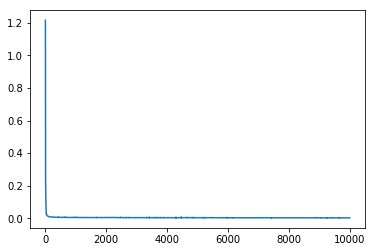

In [14]:
# plot the loss curve as the training happened so we can get an idea of how well this has worked
# reading this graph is a bit of black magic generally it should flatten out to some level that is 
# the best this loss this network can do for this data

plt.plot(hist.history["loss"])

In [15]:
# Now lets setup a function to explore the real data and the prediction from our model

def render(idxs):
    # select the list of training sequance and render its prediction and actual curves
    for idx in idxs:
        # get the past data
        past_selection = trades_past[idx:idx+1,:].flatten()
        past_x = np.arange(past_selection.shape[0])

        # get the future data 
        future_selection   = trades_future[idx:idx+1,:].flatten()
        future_x = np.arange(future_selection.shape[0]) + past_selection.shape[0]

        # make the prediction of the future data using the past data
        predict = model_train.predict(np.array(past_selection).reshape(1,-1)).flatten()

        # render them into a plot 
        fig, ax1 = plt.subplots(1,1, sharey=True, figsize=(20,7))
        ax1.plot(past_x   , past_selection, "r")
        ax1.plot(future_x , future_selection, "r")
        ax1.plot(future_x , predict, "b")
        plt.show()

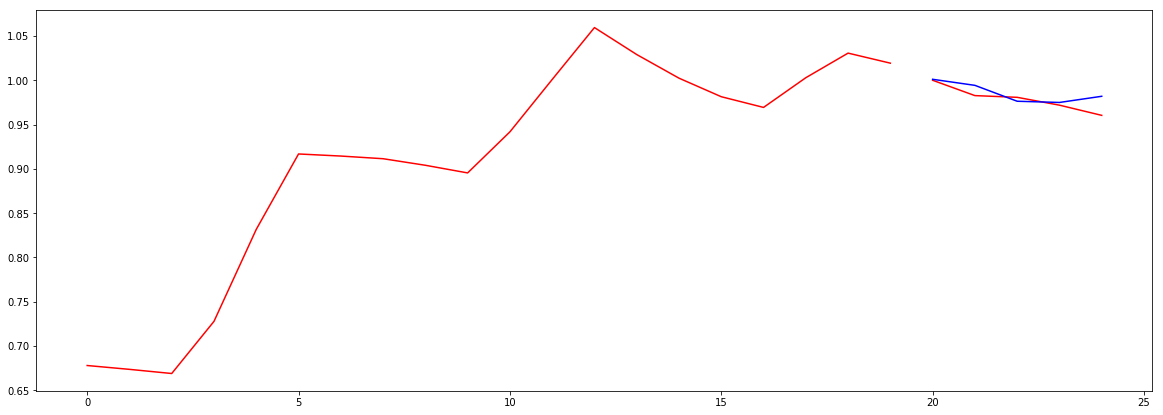

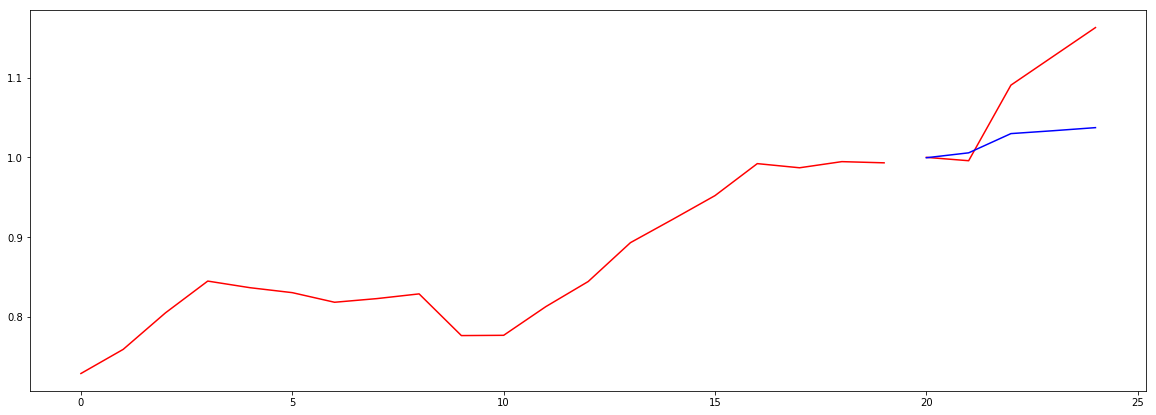

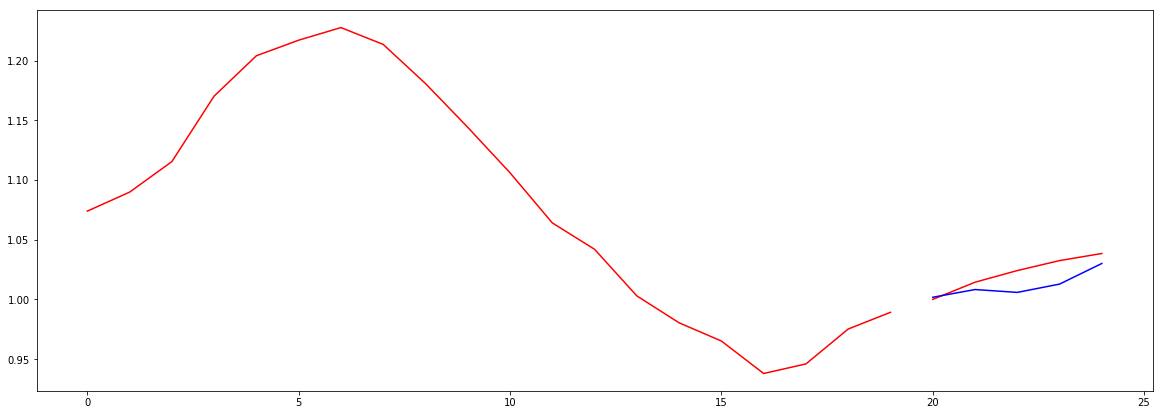

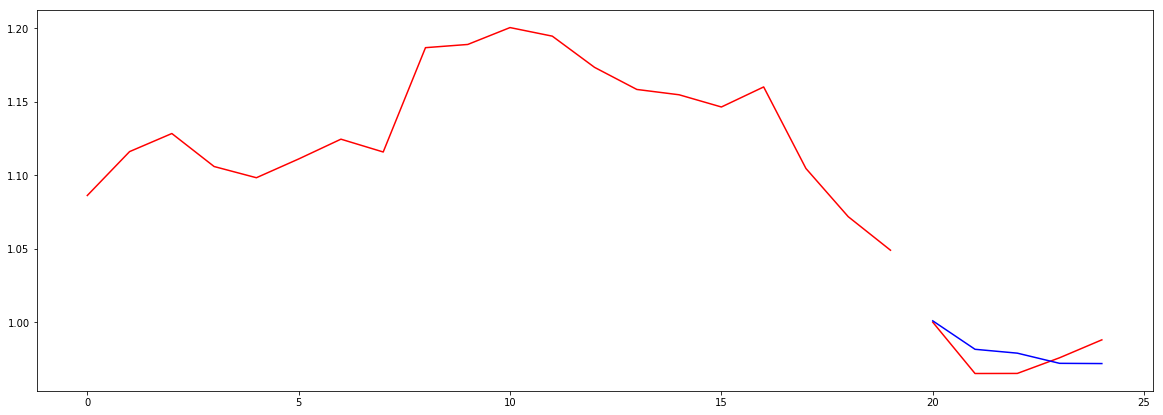

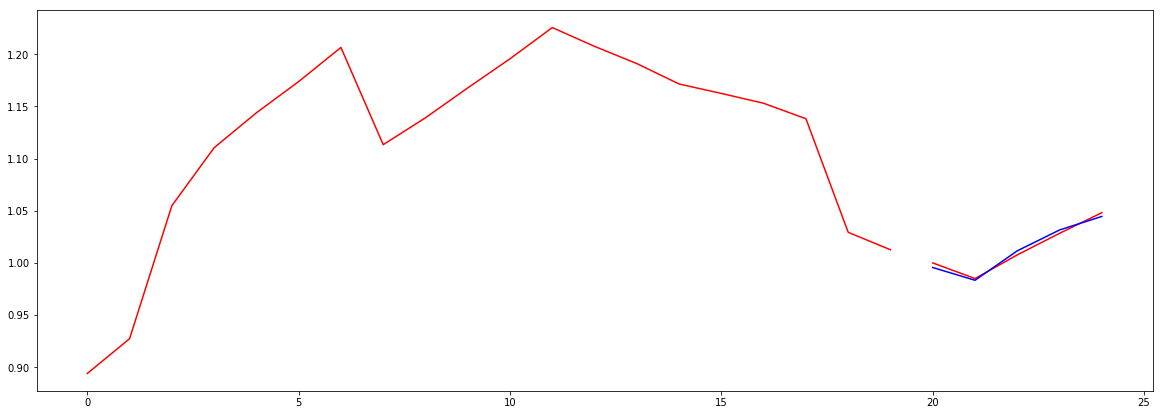

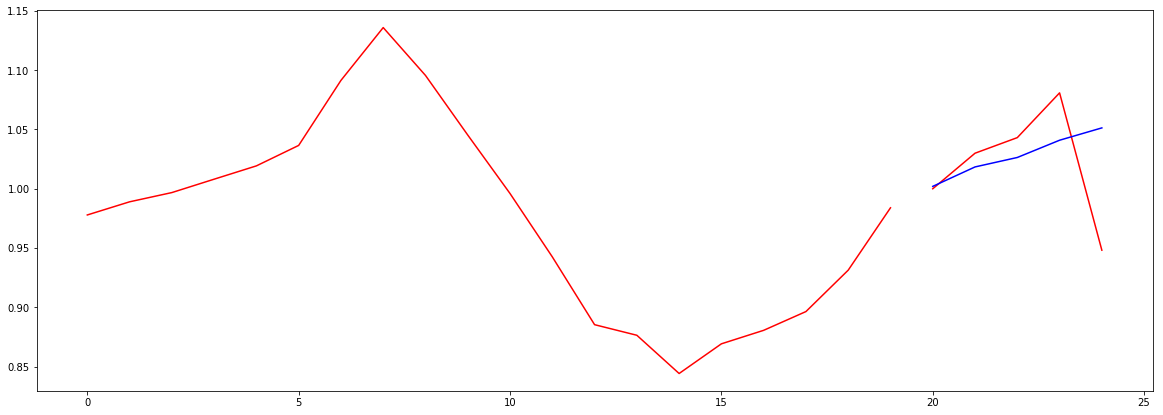

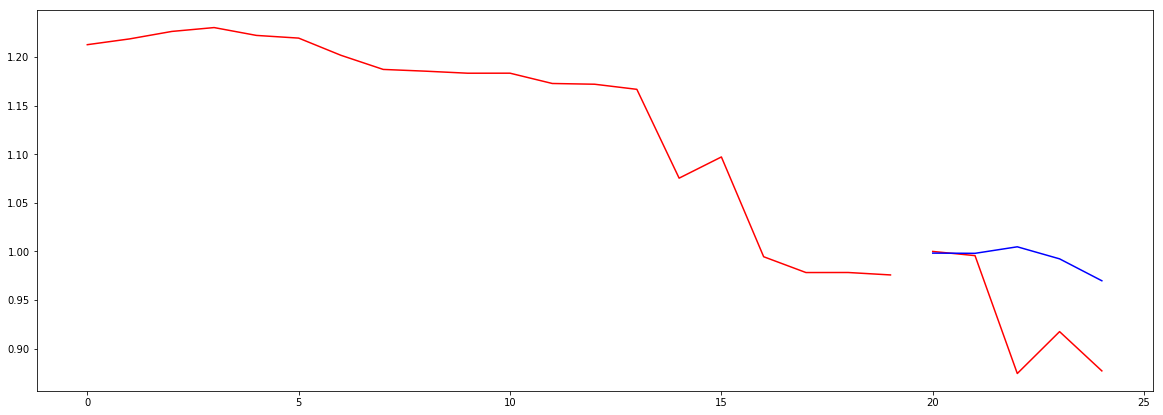

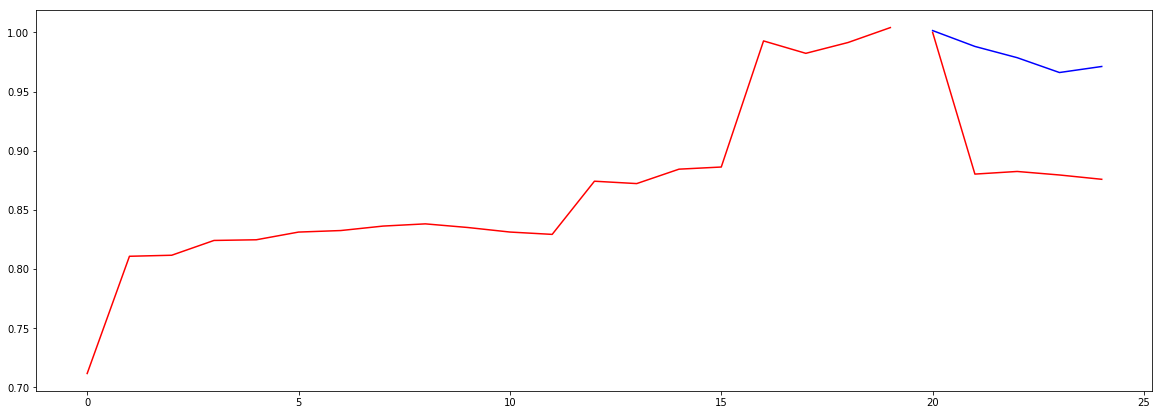

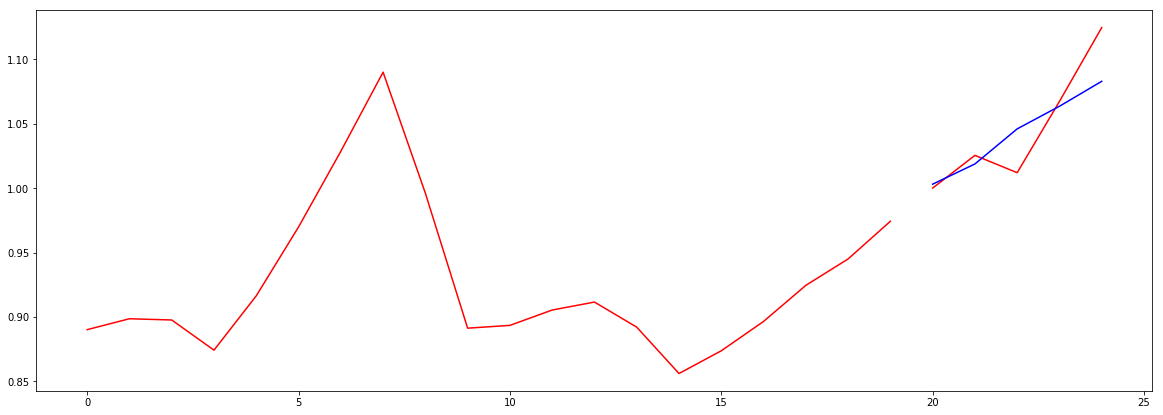

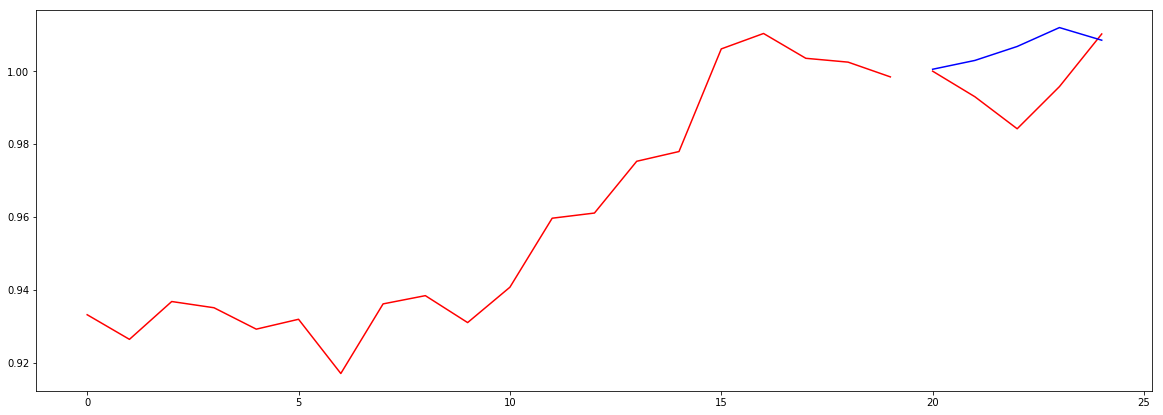

In [16]:
render(range(10))